In [505]:
# Imports 

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12,
                 'axes.spines.right': False,
                 'axes.spines.top': False,
                 'axes.linewidth':1.2,
                 'xtick.major.size': 6,
                 'xtick.major.width': 1.2,
                 'ytick.major.size': 6,
                 'ytick.major.width': 1.2,
                 'legend.frameon': False,
                 'legend.handletextpad': 0.1,
                 'figure.figsize': [10.0, 3.0],
                 'svg.fonttype': 'none',
                 'text.usetex': False})

Useful references:
- https://www.sciencedirect.com/science/article/pii/S0896627306002133?via%3Dihub

# 1. Modeling a neuron with NMDA/AMPA conductance-based synapses


<img src="images/Neuromorphic_circuit_diagram7.png" width="500">

In [506]:
def syn_driving_force(V):
    E_rev = 0          # (mV) Reversal potential
    E_ampa = E_rev - V # (mV) Driving force
    return E_ampa   

def ampa_current(E_ampa, g_ampa=1):
    '''
    E_nmda: driving force (mV)
    g_nmda: conductance (nS)
    mgblock: unitless
    '''
    i_ampa = E_ampa * g_ampa # AMPA current in pA
    i_ampa *= 1e-3 # convert to nA
    return i_ampa  

def nmda_sigmoid(V):
    '''
    V: postsynaptic voltage (mV)
    '''
    mg = 1.       # (mM) external magnesium concentration 
    vshift = -0   # (mV) shifts the mg unblock
    Kd = 9.98     # (mM) modulate Mg concentration-dependence
    gamma = 0.101 # (/mV) modulate slope of Mg sensitivity
    E_rev = 0.    # (mV) reversal potentital of NMDA channel  
    
    mgblock = 1 / (1 + np.exp(gamma * -(V-vshift)) * (mg / Kd)) # sigmoid voltage-dependent channel unblocking
    return mgblock

def nmda_current(E_nmda, mgblock=1, g_nmda=1):
    '''
    E_nmda: driving force (mV)
    g_nmda: conductance (nS)
    mgblock: unitless
    '''
    i_nmda = E_nmda * g_nmda * mgblock # NMDA current in pA
    i_nmda *= 1e-3 # convert to nA
    return i_nmda   

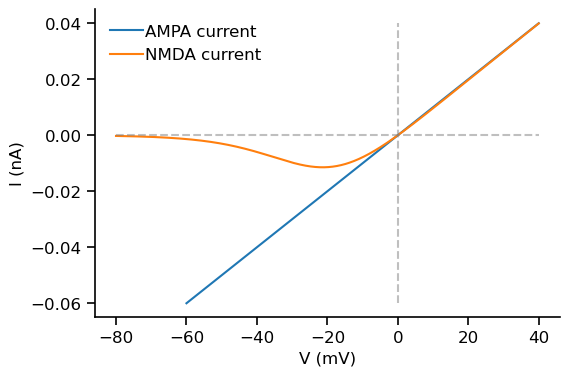

In [507]:
# Plot NMDA properties 

fig,ax = plt.subplots(figsize=[6,4])
v = np.linspace(-60,40,1000)
E_ampa = syn_driving_force(v)
i = ampa_current(E_ampa)
ax.plot(v,-i, label='AMPA current')

v = np.linspace(-80,40,1000)
E_nmda = syn_driving_force(v)
mgblock = nmda_sigmoid(v)
i = nmda_current(E_nmda,mgblock)
ax.plot(v,-i, label='NMDA current')

ax.plot([-80,40],[0,0],'--',color='gray',alpha=0.5)
ax.plot([0,0],[-0.06,0.04],'--',color='gray',alpha=0.5)
ax.set_xlabel('V (mV)')
ax.set_ylabel('I (nA)')
ax.legend()
plt.show()

In [508]:
# Run simulation with time-varying conductance + voltage-dependent driving force 

# Simulation runtime parameters
dt = 0.1  # time step (ms)
T = 300   # simulation time (ms)
time = np.arange(0., T, dt)

def run_simulation(synapse_range, tau_ampa, tau_nmda):
    first_stim_time = 50.  #ms
    delta_stim = 1. #ms
    end_time = 200. #ms
    stim_timesteps = np.arange(first_stim_time, first_stim_time+delta_stim*synapse_range, delta_stim) / dt
    stim_timesteps = np.round(stim_timesteps).astype(int) # to avoid floating point arithmetic errors

    # Model parameters
    R = 200 # cell input resistance (MOhm)
    C = 100 # cell capacitance (pF)
    cell_tau = R*C *1e-3 # time constant (ms)
    E_cell = -70
#     weights = np.random.uniform(0.2,5.,synapse_range)
    weights_ampa = np.ones(synapse_range)*5
    weights_nmda = np.ones(synapse_range)*8
    
    simulation_results = {'single_EPSPs':[np.ones(len(time))*E_cell],
                          'V':[], 'I_total':[], 'I_ampa':[], 'I_nmda':[],
                          'E_syn':[], 'g_ampa':[], 'g_nmda':[]}
    
    # Simulate single EPSPs
    for synapse_id in range(synapse_range):
        V = np.ones(len(time)) * E_cell
        this_stim_time = stim_timesteps[synapse_id]
        g_ampa = weights_ampa[synapse_id]
        g_nmda = weights_nmda[synapse_id]
        for t in range(this_stim_time, len(time)):            
            E_syn = syn_driving_force(V[t])
            I_ampa = g_ampa * E_syn *1e-3 #currents converted from pA to nA
            I_nmda = g_nmda * E_syn * nmda_sigmoid(V[t]) *1e-3 #currents converted from pA to nA
            I = (I_ampa + I_nmda) 
            
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((E_cell-V[t]) + I*R) * (1/cell_tau) 
                V[t+1] = V[t] + dVdt*dt
                dgdt_ampa = -g_ampa/tau_ampa
                g_ampa += dgdt_ampa * dt
                dgdt_nmda = -g_nmda/tau_nmda
                g_nmda += dgdt_nmda * dt
        simulation_results['single_EPSPs'].append(V)

    # Simulate combined EPSPs
    for num_synapses in range(synapse_range+1):
        # Initialize simulation variables
        V = np.ones(len(time)) * E_cell
        I = np.zeros(len(time))
        I_ampa = np.zeros(len(time))
        I_nmda = np.zeros(len(time))
        E_syn = np.zeros(len(time))
        g_ampa = np.zeros(len(time))
        g_nmda = np.zeros(len(time))
        
        stim_timesteps_sub = stim_timesteps[0:num_synapses]

        for t in range(len(time)): 
            if t in stim_timesteps_sub:
                active_synapse_ids = np.where(stim_timesteps_sub==t)[0]
                g_ampa[t] += np.sum(weights_ampa[active_synapse_ids])    # nS   
                g_nmda[t] += np.sum(weights_nmda[active_synapse_ids])    # nS                

            E_syn[t] = syn_driving_force(V[t])
            I_ampa[t] = g_ampa[t] * E_syn[t] *1e-3 #currents converted from pA to nA
            I_nmda[t] = g_nmda[t] * E_syn[t] * nmda_sigmoid(V[t]) *1e-3 #currents converted from pA to nA
            I[t] = I_ampa[t] + I_nmda[t]
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((E_cell-V[t]) + I[t]*R) * (1/cell_tau) 
                V[t+1] = V[t] + dVdt*dt

                dgdt_ampa = -g_ampa[t]/tau_ampa
                g_ampa[t+1] = g_ampa[t] + dgdt_ampa*dt
                dgdt_nmda = -g_nmda[t]/tau_nmda
                g_nmda[t+1] = g_nmda[t] + dgdt_nmda * dt
                
        simulation_results['V'].append(V)
        simulation_results['I_total'].append(I)
        simulation_results['I_ampa'].append(I_ampa)
        simulation_results['I_nmda'].append(I_nmda)
        simulation_results['E_syn'].append(E_syn)
        simulation_results['g_ampa'].append(g_ampa)
        simulation_results['g_nmda'].append(g_nmda)
    simulation_results['stim_times'] = stim_timesteps

    for key,value in simulation_results.items():
        simulation_results[key] = np.array(value).T
        
    return simulation_results

synapse_range = 8
simulation_results = run_simulation(synapse_range, tau_ampa=2, tau_nmda=80)

If synaptic driving force is voltage-dependent, the voltage steps get smaller with each successive synapse, 
resulting in strongly sub-linear summation of the individual potentials


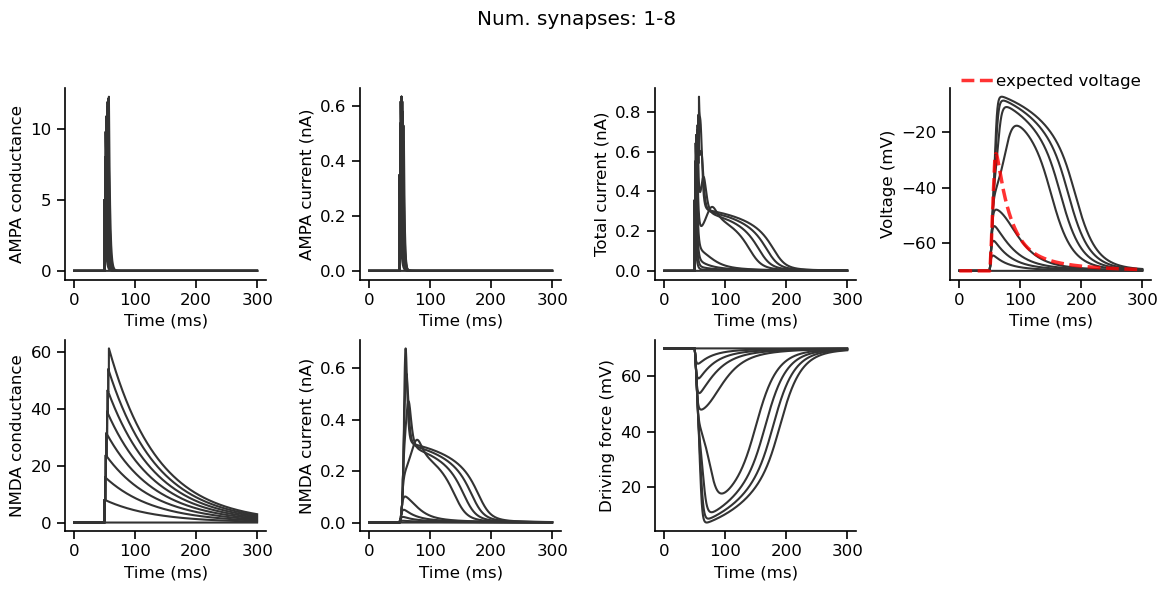

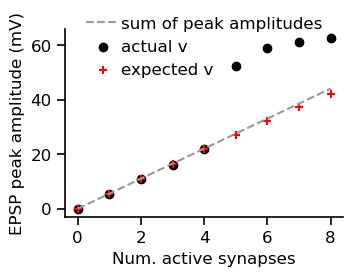

In [509]:
# Plot simulation results 

fig,ax = plt.subplots(2,4,figsize=(12,6))
titles = {'V': 'Voltage (mV)', 'I_total': 'Total current (nA)', 'E_syn': 'Driving force (mV)',
          'I_ampa': 'AMPA current (nA)', 'I_nmda': 'NMDA current (nA)', 
          'g_ampa': 'AMPA conductance',  'g_nmda': 'NMDA conductance'}

line_color = [0.2,0.2,0.2]
ax[0,0].plot(time, simulation_results['g_ampa'], c=line_color)
ax[0,0].set_xlabel('Time (ms)')
ax[0,0].set_ylabel(titles['g_ampa'])

ax[1,0].plot(time, simulation_results['g_nmda'], c=line_color)
ax[1,0].set_xlabel('Time (ms)')
ax[1,0].set_ylabel(titles['g_nmda'])

ax[0,1].plot(time, simulation_results['I_ampa'], c=line_color)
ax[0,1].set_xlabel('Time (ms)')
ax[0,1].set_ylabel(titles['I_ampa'])

ax[1,1].plot(time, simulation_results['I_nmda'], c=line_color)
ax[1,1].set_xlabel('Time (ms)')
ax[1,1].set_ylabel(titles['I_nmda'])

ax[1,2].plot(time, simulation_results['E_syn'], c=line_color)
ax[1,2].set_xlabel('Time (ms)')
ax[1,2].set_ylabel(titles['E_syn'])

ax[0,2].plot(time, simulation_results['I_total'], c=line_color)
ax[0,2].set_xlabel('Time (ms)')
ax[0,2].set_ylabel(titles['I_total'])

ax[0,3].plot(time, simulation_results['V'], c=line_color)
ax[0,3].set_xlabel('Time (ms)')
ax[0,3].set_ylabel(titles['V'])

baselines = simulation_results['single_EPSPs'][0,:]
summed_EPSP_trace = np.sum(simulation_results['single_EPSPs']-baselines,axis=1) + baselines[0]
ax[0,3].plot(time,summed_EPSP_trace,'--',linewidth=2.5,alpha=0.8,color='r', label='expected voltage')
ax[0,3].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

ax[1,3].axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle(f'Num. synapses: 1-{synapse_range}')


singleEPSP_amplitudes = np.max(simulation_results['single_EPSPs'],axis=0) - baselines
linear_sum = np.cumsum(singleEPSP_amplitudes)
expected_amplitudes = np.max(np.cumsum(simulation_results['single_EPSPs']-baselines,axis=1),axis=0)
multiEPSP_amplitudes = np.max(simulation_results['V'],axis=0) - baselines
num_EPSPs = len(multiEPSP_amplitudes)

fig,ax = plt.subplots(figsize=[5,4])
ax.plot(np.arange(num_EPSPs), linear_sum, '--', c=[0.6,0.6,0.6], label='sum of peak amplitudes')
ax.scatter(np.arange(num_EPSPs), multiEPSP_amplitudes, color='k', label='actual v')
ax.scatter(np.arange(num_EPSPs), expected_amplitudes, marker='+',color='r',label='expected v')
ax.set_ylabel('EPSP peak amplitude (mV)')
ax.set_xlabel('Num. active synapses')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))


plt.tight_layout(pad=5)
plt.subplots_adjust(top=0.8)

print('If synaptic driving force is voltage-dependent, the voltage steps get smaller with each successive synapse, \nresulting in strongly sub-linear summation of the individual potentials')

plt.show()

# <font color='blue'> 2. Emulating VO2 volatile resistor properties </font>

In [ ]:
# def heating_sigmoid(temp, a=0.2):
#     slow_component = 3e7/(temp+90) - 1.5e5
#     sigm = (1-a) / (1+np.exp((temp-70)/1)) + 0.2
#     minR = 100
#     R = slow_component*sigm + minR
#     return R

# def get_heating_sigmoid_coeff(temp,R):
#     slow_component = 3e7/(temp+90) - 1.5e5
#     minR = 100
#     a = ((minR - R)/slow_component + 0.2) * (1+np.exp((temp-70)/1)) + 1
#     return a

# def cooling_sigmoid(temp, a=0.2):
#     slow_component = 3e7/(temp+90) - 1.5e5
#     sigm = (1-a) / (1+np.exp((temp-60)/2)) + a
#     minR = 100
#     R = slow_component*sigm + minR
#     return R

# def get_cooling_sigmoid_coeff(temp,R):
#     slow_component = 3e7/(temp+90) - 1.5e5
#     sigm_denominator = (1+np.exp((temp-60)/2))
#     minR = 100
#     a = (sigm_denominator*(R - minR)/slow_component - 1)/(sigm_denominator -1 +1e-10)
#     return a


a heat= -0.28695652173913055
a cool= 0.3059052401542763


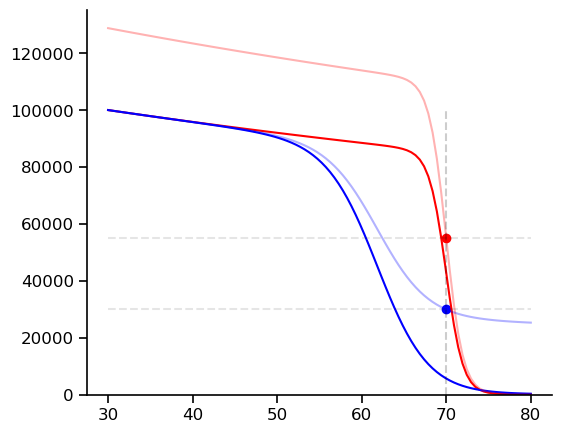

In [611]:
# Define material properties of VO2 volatile resistors 

class Volatile_Resistor():
    def __init__(self, dt, temperature=30):
        self.dt = dt
        self.R = self.heating_sigmoid(temperature)
        self.controlI = 0
        self.internal_temp = temperature
        self.ambient_temp = temperature
        self.a = 0.001
        
        self.R_history = []
        self.controlI_history = [0]
        self.temp_history = [temperature]

    def heating_sigmoid(self, temp, a=0.001):
        slow_component = 2.3e7/(temp+200)
        sigm = (1-a) / (1+np.exp((temp-70)/1)) + 0.001
        minR = 100
        R = slow_component*sigm + minR
        return R

    def get_heating_sigmoid_coeff(self, temp,R):
        slow_component = 2.3e7/(temp+200)
        minR = 100
        a = ((minR - R)/slow_component + 0.001) * (1+np.exp((temp-70)/1)) + 1
        return a

    def cooling_sigmoid(self, temp, a=0.001):
        slow_component = 2.3e7/(temp+200)
        sigm = (1-a) / (1+np.exp((temp-62)/3)) + a
        minR = 100
        R = slow_component*sigm + minR
        return R
    
    def get_cooling_sigmoid_coeff(self, temp,R):
        slow_component = 2.3e7/(temp+200)
        sigm_denominator = (1+np.exp((temp-62)/3))
        minR = 100
        a = (sigm_denominator*(R - minR)/slow_component - 1)/(sigm_denominator -1 +1e-10)
        return a
    
    def time_step(self):

#         # Increase the internal temperature of the device based on the applied current
#         dTemp = self.R*(self.controlI)**2 / 1e8
#         self.internal_temp = self.internal_temp + dTemp*dt
        target_temp = 70 + self.controlI/10
        if target_temp > self.internal_temp:
            self.internal_temp = self.internal_temp + (target_temp - self.internal_temp)/100
        

        # Decay the internal temperature of the device exponentially towards ambient temperature
        dTemp = -1* (self.internal_temp - self.ambient_temp) / 200
        self.internal_temp = self.internal_temp + dTemp*dt
        
        if len(self.temp_history)>2:
            # Compute heating transfer function (sigmoid)
            if self.internal_temp > self.temp_history[-1]:
                if self.temp_history[-1] < self.temp_history[-2]: #if temperature changed direction: recompute sigmoid
                    self.a = self.get_heating_sigmoid_coeff(self.temp_history[-1], self.R)
                    print('Heating!', self.internal_temp)
                    assert (self.a>=0 and self.a<=1), f'Heating sigmoid out of bounds: a={self.a} T={self.temp_history[-1]}, R={self.R}'
                self.R = self.heating_sigmoid(self.internal_temp, self.a)

            # Compute cooling transfer function (sigmoid)
            elif self.internal_temp < self.temp_history[-1]:
                if self.temp_history[-1] > self.temp_history[-2]: #if temperature changed direction: recompute sigmoid
                    self.a = self.get_cooling_sigmoid_coeff(self.temp_history[-1], self.R)
#                     assert (self.a>=0 and self.a<=1), f'Cooling sigmoid out of bounds: a={self.a} T={self.temp_history[-1]}, R={self.R}'
                self.R = self.cooling_sigmoid(self.internal_temp, self.a)

        self.R_history.append(self.R)
        self.controlI_history.append(self.controlI)
        self.temp_history.append(self.internal_temp)
    
    @property
    def g(self):
        # Convert from resistance (Ohm) to conductance (nS)
        return 1e9/self.R


temp = np.linspace(30,80,100)
VO2 = Volatile_Resistor(dt=1)

func1 = VO2.heating_sigmoid(temp)
coord1 = (70, 5.5e4)
a = VO2.get_heating_sigmoid_coeff(temp=coord1[0],R=coord1[1])
print(f'a heat= {a}')
func2 = VO2.heating_sigmoid(temp, a)

func3 = VO2.cooling_sigmoid(temp)
coord2 = (70, 3e4)
a = VO2.get_cooling_sigmoid_coeff(temp=coord2[0],R=coord2[1])
print(f'a cool= {a}')
func4 = VO2.cooling_sigmoid(temp, a)

fig, ax = plt.subplots(figsize=[6,5])
ax.plot(temp,func1,'r')
ax.plot(temp,func3,'b')

ax.plot(temp,func2,'r', alpha=0.3)
ax.plot(temp,func4,'b', alpha=0.3)

ax.scatter(coord1[0],coord1[1],c='r')
ax.plot([coord1[0],coord1[0]],[0,1e5],'k--',alpha=0.1)
ax.plot([30,80],[coord1[1],coord1[1]],'k--',alpha=0.1)

ax.scatter(coord2[0],coord2[1],c='b')
ax.plot([coord2[0],coord2[0]],[0,1e5],'k--',alpha=0.1)
ax.plot([30,80],[coord2[1],coord2[1]],'k--',alpha=0.1)

ax.set_ylim(bottom=0)
plt.show()


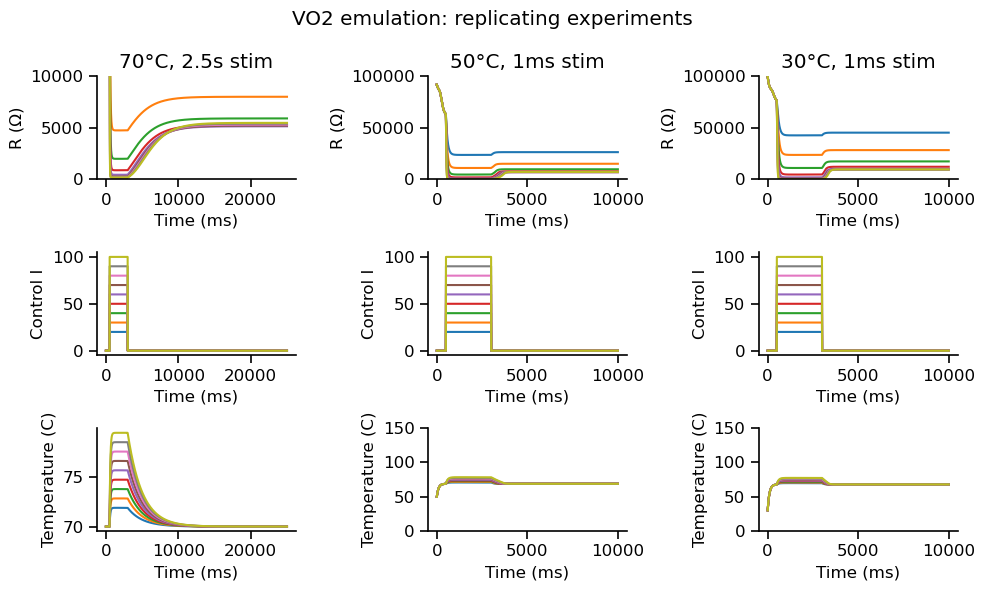

In [612]:
# Plot test pulses: replicating experiments 

# baselineI = g_volatile.compute_controlI(20)
# print(f"Pulse control V = {pulseI}")
# print(f"Baseline control V (to set the decay tau) = {baselineI}")
# print(f"Tau = {round(g_volatile.tau(baselineI))} ms")

def VO2_test_pulse(dt, T, stim_time, temperature):
    '''
    Simulate a test pulse of a VO2 volatile resistor
    :param dt: time step (ms)
    :param T: simulation time (ms)
    '''

    time = np.arange(0., T, dt)

    R_hist_ls = []
    controlI_hist_ls = []
    temp_hist_ls = []
    for pulseI in np.arange(20,110,10):
        g_volatile = Volatile_Resistor(dt, temperature=temperature)
        for t in time:
            if t>stim_time[0] and t<stim_time[1]:
                g_volatile.controlI = pulseI  
            else:
                g_volatile.controlI = 0
            g_volatile.time_step()
        R_hist_ls.append(g_volatile.R_history)
        controlI_hist_ls.append(g_volatile.controlI_history[1:])
        temp_hist_ls.append(g_volatile.temp_history[1:])

    R_hist = np.array(R_hist_ls).T
    controlI_hist = np.array(controlI_hist_ls).T
    temp_hist = np.array(temp_hist_ls).T
    return time, R_hist, controlI_hist, temp_hist

fig,ax = plt.subplots(3,3,figsize=[10,6])

time, R_hist, controlI_hist, temp_hist = VO2_test_pulse(dt=1,T=25000, stim_time=(500,3000), temperature=70)
ax[0,0].plot(time, R_hist)
ax[0,0].set_xlabel('Time (ms)')
ax[0,0].set_ylabel('R (Ω)')
ax[0,0].set_title('70°C, 2.5s stim')
ax[0,0].set_ylim([0,1e4])

ax[1,0].plot(time, controlI_hist)
ax[1,0].set_xlabel('Time (ms)')
ax[1,0].set_ylabel('Control I')

ax[2,0].plot(time, temp_hist)
ax[2,0].set_xlabel('Time (ms)')
ax[2,0].set_ylabel('Temperature (C)')
# ax[2,0].set_ylim([30,100])

# time, R_hist, controlI_hist, temp_hist = VO2_test_pulse(dt=0.1,T=50, stim_time=(3,4), temperature=50)
time, R_hist, controlI_hist, temp_hist = VO2_test_pulse(dt=1,T=10000, stim_time=(500,3000), temperature=50)
ax[0,1].plot(time, R_hist)
ax[0,1].set_xlabel('Time (ms)')
ax[0,1].set_ylabel('R (Ω)')
ax[0,1].set_title('50°C, 1ms stim')
ax[0,1].set_ylim([0,1e5])

ax[1,1].plot(time, controlI_hist)
ax[1,1].set_xlabel('Time (ms)')
ax[1,1].set_ylabel('Control I')

ax[2,1].plot(time, temp_hist)
ax[2,1].set_xlabel('Time (ms)')
ax[2,1].set_ylabel('Temperature (C)')
ax[2,1].set_ylim([0,150])

# time, R_hist, controlI_hist, temp_hist = VO2_test_pulse(dt=0.1,T=50, stim_time=(3,4), temperature=30)
time, R_hist, controlI_hist, temp_hist = VO2_test_pulse(dt=1,T=10000, stim_time=(500,3000), temperature=30)
ax[0,2].plot(time, R_hist)
ax[0,2].set_xlabel('Time (ms)')
ax[0,2].set_ylabel('R (Ω)')
ax[0,2].set_title('30°C, 1ms stim')
ax[0,2].set_ylim([0,1e5])

ax[1,2].plot(time, controlI_hist)
ax[1,2].set_xlabel('Time (ms)')
ax[1,2].set_ylabel('Control I')

ax[2,2].plot(time, temp_hist)
ax[2,2].set_xlabel('Time (ms)')
ax[2,2].set_ylabel('Temperature (C)')
ax[2,2].set_ylim([0,150])

plt.suptitle('VO2 emulation: replicating experiments')

plt.tight_layout()
plt.show()

In [201]:
# Define material properties of VO2 volatile resistors 

class Volatile_Resistor():
    def __init__(self, dt, temperature=70):
        self.dt = dt
        self.R = 5000+220
        self.R_history = []
        self.controlI = 0
        self.controlI_history = []
        self.temperature = temperature
        self.peak_R = self.R
        
    def time_step(self):
        self.R_history.append(self.R)
        self.controlI_history.append(self.controlI)

        R_eq = self.transfer_func(self.controlI)         

        if self.R > R_eq:
            self.peak_R = R_eq
            rise_tau = np.maximum(self.dt, self.rise_tau(R=self.R, temperature=self.temperature))
            dRdt = (R_eq - self.R) / rise_tau
        else:
            decay_tau = np.maximum(self.dt, self.decay_tau(R=self.peak_R, temperature=self.temperature))    
#             dRdt = (R_eq - self.R) / decay_tau
            dRdt = (R_eq - self.R)**0.95 / decay_tau
            
        self.R += dRdt * self.dt
        
    def transfer_func(self, controlI):
        '''
        Function to convert between controlI and resistance
        controlI: current in units of mA
        '''        
        R_eq = 5000*np.exp(-0.12*controlI)+220 # (Ohm)
        g_eq  = 1 / R_eq * 1e9 # convert to conductance (nS)
        return R_eq
    
    def inv_transfer_func(self, R):
        controlI = np.log((R-220)/5000)/(-0.12)
        return controlI
        
    def decay_tau(self, controlI=None, R=None, temperature=70):
        if controlI is None:
            controlI = self.inv_transfer_func(R)
#         tau = (0.44 * np.sqrt(controlI) + 1.45) * np.exp(0.2*(temperature-70))
#         tau = (0.029 * controlI + 3) * np.exp(0.2*(temperature-70))
#         tau = (0.018 * controlI**1.1 + 3) * np.exp(0.2*(temperature-70))
        tau = (0.018 * controlI**1.1 + 0.5) * np.exp(0.2*(temperature-70))
        tau = tau * 1e3 # convert to ms
        return tau 
    
    def rise_tau(self, R=None, temperature=70):
        tau = 1/(R+200) * np.exp(0.2*(temperature-72))
        tau = tau * 1e3 # convert to ms
        return tau
    
    @property
    def g(self):
        # Convert from resistance (Ohm) to conductance (nS)
        return 1e9/self.R


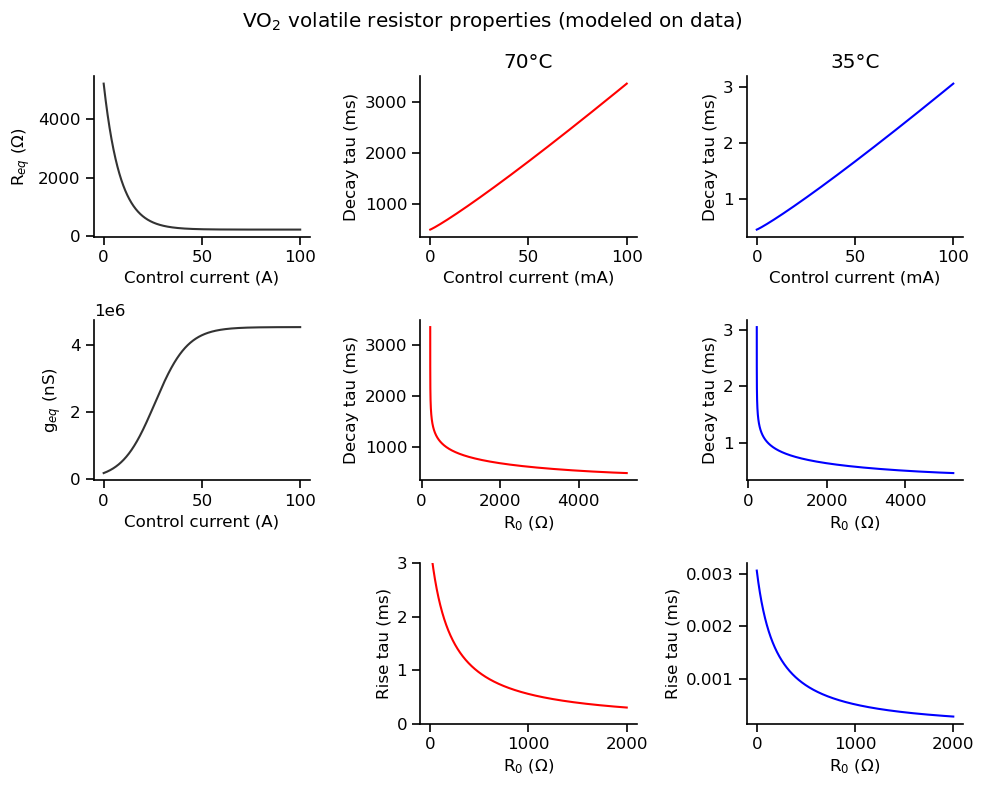

In [13]:
# Plot properties 

# Simulation runtime parameters
dt = 0.1  # time step (ms)
T = 300   # simulation time (ms)
time = np.arange(0., T, dt)

line_color = [0.2,0.2,0.2]
fig,ax = plt.subplots(3,3,figsize=[10,8])
g_volatile = Volatile_Resistor(dt)
controlI = np.linspace(0,100,1000)
R_eq = g_volatile.transfer_func(controlI)
g_eq = 1e9 / R_eq

ax[0,0].plot(controlI,R_eq, c=line_color)
ax[0,0].set_xlabel('Control current (A)')
ax[0,0].set_ylabel('R$_{eq}$ (Ω)')

ax[1,0].plot(controlI,g_eq, c=line_color)
ax[1,0].set_xlabel('Control current (A)')
ax[1,0].set_ylabel('g$_{eq}$ (nS)')

ax[0,1].plot(controlI,g_volatile.decay_tau(controlI=controlI,temperature=70),c='r',label='70°C')
ax[0,1].set_title('70°C')
ax[0,1].set_xlabel('Control current (mA)')
ax[0,1].set_ylabel('Decay tau (ms)')

ax[0,2].plot(controlI,g_volatile.decay_tau(controlI=controlI,temperature=35),c='b',label='30°C')
ax[0,2].set_title('35°C')
ax[0,2].set_xlabel('Control current (mA)')
ax[0,2].set_ylabel('Decay tau (ms)')

ax[1,1].plot(R_eq,g_volatile.decay_tau(R=R_eq,temperature=70),c='r')
ax[1,1].set_xlabel('R$_{0}$ (Ω)')
ax[1,1].set_ylabel('Decay tau (ms)')

ax[1,2].plot(R_eq,g_volatile.decay_tau(R=R_eq,temperature=35),c='b')
ax[1,2].set_xlabel('R$_{0}$ (Ω)')
ax[1,2].set_ylabel('Decay tau (ms)')

ax[2,0].axis('off')
R_range = np.linspace(0,2000,1000)
ax[2,1].plot(R_range,g_volatile.rise_tau(R=R_range,temperature=70),c='r')
ax[2,1].set_xlabel('R$_{0}$ (Ω)')
ax[2,1].set_ylabel('Rise tau (ms)')
ax[2,1].set_ylim([0,3])

R_range = np.linspace(0,2000,1000)
ax[2,2].plot(R_range,g_volatile.rise_tau(R=R_range,temperature=35),c='b')
ax[2,2].set_xlabel('R$_{0}$ (Ω)')
ax[2,2].set_ylabel('Rise tau (ms)')

plt.suptitle('VO$_{2}$ volatile resistor properties (modeled on data)')
plt.tight_layout()
plt.show()

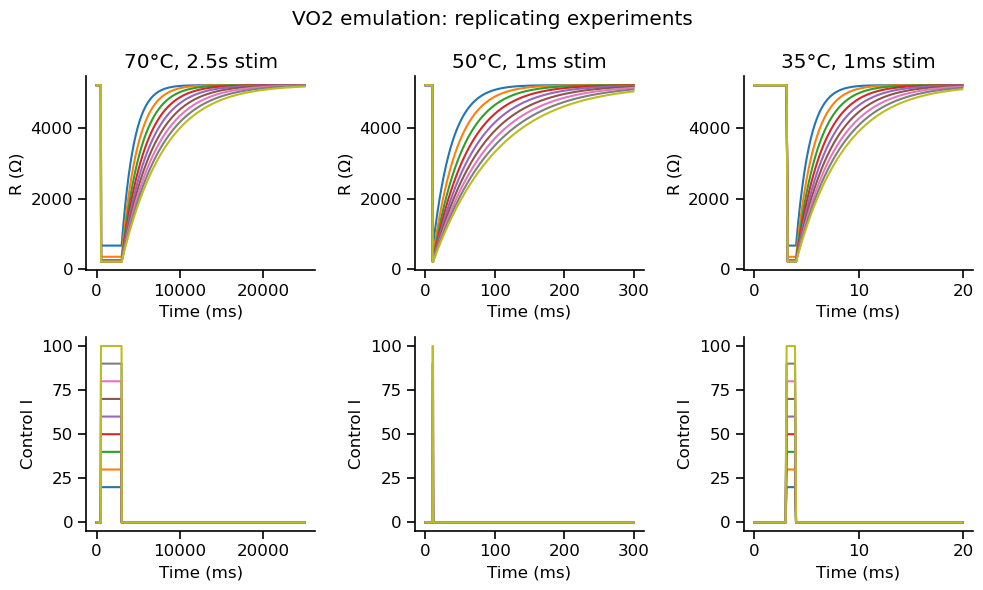

In [14]:
# Plot test pulses: replicating experiments 

# baselineI = g_volatile.compute_controlI(20)
# print(f"Pulse control V = {pulseI}")
# print(f"Baseline control V (to set the decay tau) = {baselineI}")
# print(f"Tau = {round(g_volatile.tau(baselineI))} ms")

def VO2_test_pulse(dt, T, stim_time, temperature):
    '''
    Simulate a test pulse of a VO2 volatile resistor
    :param dt: time step (ms)
    :param T: simulation time (ms)
    '''

    time = np.arange(0., T, dt)

    R_hist_ls = []
    controlI_hist_ls = []
    for pulseI in np.arange(20,110,10):
        g_volatile = Volatile_Resistor(dt, temperature=temperature)
        for t in time:
            if t>stim_time[0] and t<stim_time[1]:
                g_volatile.controlI = pulseI  
            else:
                g_volatile.controlI = 0
            g_volatile.time_step()
        R_hist_ls.append(g_volatile.R_history)
        controlI_hist_ls.append(g_volatile.controlI_history)

    R_hist = np.array(R_hist_ls).T
    controlI_hist = np.array(controlI_hist_ls).T
    return time, R_hist, controlI_hist

fig,ax = plt.subplots(2,3,figsize=[10,6])

time, R_hist, controlI_hist = VO2_test_pulse(dt=10,T=25000, stim_time=(500,3000), temperature=70)
ax[0,0].plot(time, R_hist)
ax[0,0].set_xlabel('Time (ms)')
ax[0,0].set_ylabel('R (Ω)')
ax[0,0].set_title('70°C, 2.5s stim')

ax[1,0].plot(time, controlI_hist)
ax[1,0].set_xlabel('Time (ms)')
ax[1,0].set_ylabel('Control I')

time, R_hist, controlI_hist = VO2_test_pulse(dt=0.1,T=300, stim_time=(10,11), temperature=50)
ax[0,1].plot(time, R_hist)
ax[0,1].set_xlabel('Time (ms)')
ax[0,1].set_ylabel('R (Ω)')
ax[0,1].set_title('50°C, 1ms stim')

ax[1,1].plot(time, controlI_hist)
ax[1,1].set_xlabel('Time (ms)')
ax[1,1].set_ylabel('Control I')

time, R_hist, controlI_hist = VO2_test_pulse(dt=0.1,T=20, stim_time=(3,4), temperature=35)
ax[0,2].plot(time, R_hist)
ax[0,2].set_xlabel('Time (ms)')
ax[0,2].set_ylabel('R (Ω)')
ax[0,2].set_title('35°C, 1ms stim')

ax[1,2].plot(time, controlI_hist)
ax[1,2].set_xlabel('Time (ms)')
ax[1,2].set_ylabel('Control I')

plt.suptitle('VO2 emulation: replicating experiments')

plt.tight_layout()
plt.show()

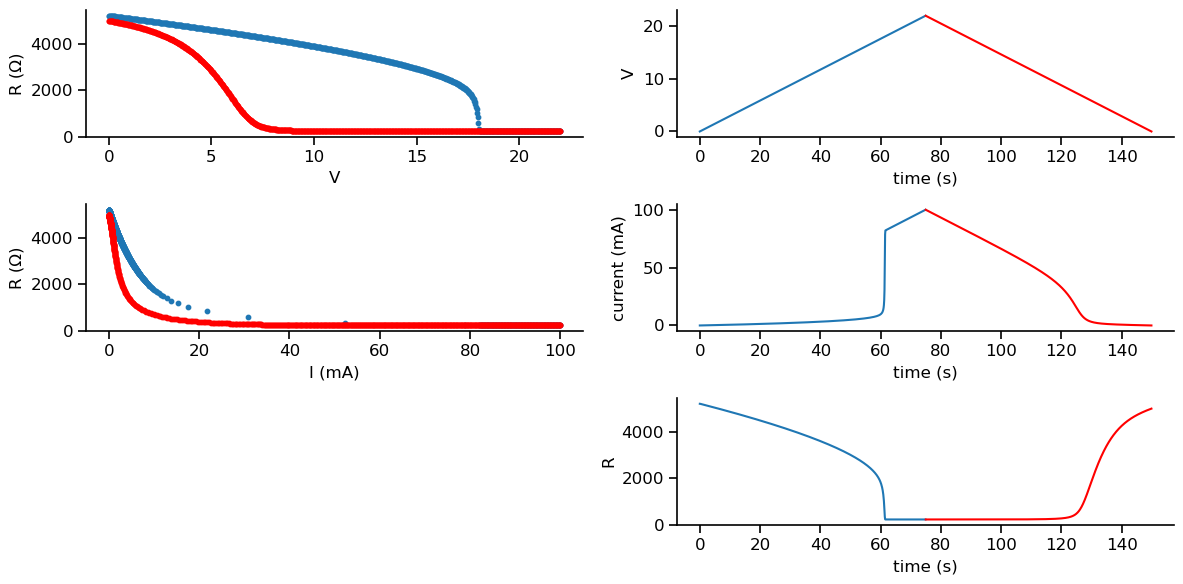

In [15]:
# Plot voltage ramp 

dt = 100 #ms
T = 150000 #ms
time = np.arange(0,T,dt)

v1 = np.linspace(0,22,len(time)//2)
v2 = np.flip(v1)
V = np.concatenate([v1,v2])

g_volatile = Volatile_Resistor(dt,temperature=70)

for t in range(len(time)):
    g_volatile.controlI = V[t] / g_volatile.R * 1000
    g_volatile.time_step()
    
time = time/1000

fig, ax = plt.subplots(3,2,figsize=[12,6])

ax[0,0].scatter(V[:len(v1)],g_volatile.R_history[:len(v1)],s=10)
ax[0,0].scatter(V[len(v1):],g_volatile.R_history[len(v1):],s=10,c='r')
ax[0,0].set_xlabel('V')
ax[0,0].set_ylabel('R (Ω)')

ax[1,0].scatter(g_volatile.controlI_history[:len(v1)],g_volatile.R_history[:len(v1)],s=10)
ax[1,0].scatter(g_volatile.controlI_history[len(v1):],g_volatile.R_history[len(v1):],s=10,c='r')
ax[1,0].set_xlabel('I (mA)')
ax[1,0].set_ylabel('R (Ω)')

ax[2,0].axis('off')

ax[0,1].plot(time[:len(v1)],V[:len(v1)])
ax[0,1].plot(time[len(v1):],V[len(v1):],'r')
ax[0,1].set_xlabel('time (s)')
ax[0,1].set_ylabel('V')

ax[1,1].plot(time[:len(v1)],g_volatile.controlI_history[:len(v1)])
ax[1,1].plot(time[len(v1):],g_volatile.controlI_history[len(v1):],'r')
ax[1,1].set_xlabel('time (s)')
ax[1,1].set_ylabel('current (mA)')

ax[2,1].plot(time[:len(v1)],g_volatile.R_history[:len(v1)])
ax[2,1].plot(time[len(v1):],g_volatile.R_history[len(v1):],'r')
ax[2,1].set_xlabel('time (s)')
ax[2,1].set_ylabel('R')


plt.tight_layout()
plt.show()

# <font color='blue'> 3. Simulating AMPA/NMDA conductance-based synapses with neuromorphic hardware </font>

<img src="images/Neuromorphic_circuit_diagram8.png" width="350">

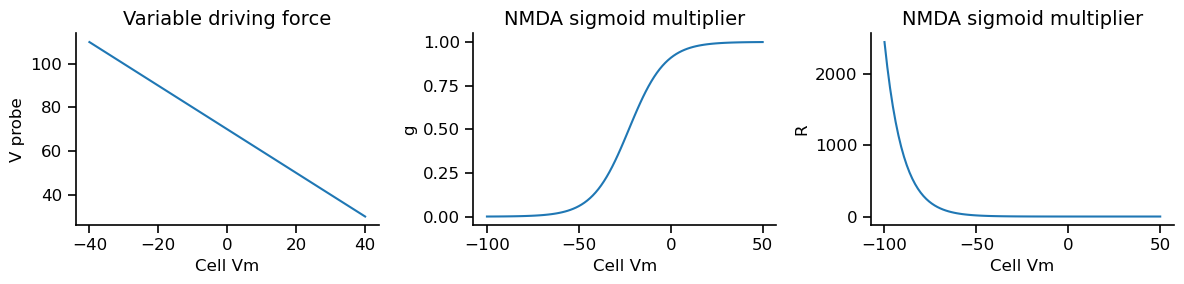

In [16]:
# Define variable probe voltage 

def compute_probeV(V_cell):
    '''Synapse driving force, computed as a function of the cell membrane potential (Vm)'''
    E_rev = 70           # (mV) Reversal potential
    V_probe = E_rev - V_cell # (mV) Driving force
    return V_probe

def nmda_sigmoid(V):
    '''
    V: postsynaptic voltage (mV)
    '''
    mg = 1.       # (mM) external magnesium concentration 
    vshift = -0   # (mV) shifts the mg unblock
    Kd = 9.98     # (mM) modulate Mg concentration-dependence
    gamma = 0.101 # (/mV) modulate slope of Mg sensitivity
    E_rev = 0.    # (mV) reversal potentital of NMDA channel  
    
    mgblock = 1 / (1 + np.exp(gamma * -(V-vshift)) * (mg / Kd)) # sigmoid voltage-dependent channel unblocking
    return mgblock
   
# Plot probeV function
fig,ax = plt.subplots(1,3, figsize=[12,3])
V_cell = np.linspace(-40,40,100)
ax[0].plot(V_cell, compute_probeV(V_cell))
ax[0].set_xlabel('Cell Vm')
ax[0].set_ylabel("V probe")
# ax.plot([0,0],[30,110],'--',color=[.8,.8,.8])
# ax.plot([-40,40],[0,0],'--',color=[.8,.8,.8])
ax[0].set_title('Variable driving force',fontsize=14)

V_cell = np.linspace(-100,50,100)
ax[1].plot(V_cell, nmda_sigmoid(V_cell))
ax[1].set_xlabel('Cell Vm')
ax[1].set_ylabel("g")
ax[1].set_title('NMDA sigmoid multiplier',fontsize=14)

V_cell = np.linspace(-100,50,100)
ax[2].plot(V_cell, 1/nmda_sigmoid(V_cell))
ax[2].set_xlabel('Cell Vm')
ax[2].set_ylabel("R")
ax[2].set_title('NMDA sigmoid multiplier',fontsize=14)

plt.tight_layout()
plt.show()

In [17]:
# Run hardware simulation with voltage-dependent V_probe 

# Simulation runtime parameters
dt = 0.1  # time step (ms)
T = 300   # simulation time (ms)
time = np.arange(0., T, dt)

def run_simulation(synapse_range, tau_ampa, tau_nmda):
    first_stim_time = 50.  #ms
    delta_stim = 1. #ms
    end_time = 200. #ms
    stim_timesteps = np.arange(first_stim_time, first_stim_time+delta_stim*synapse_range, delta_stim) / dt
    stim_timesteps = np.round(stim_timesteps).astype(int) # to avoid floating point arithmetic errors
    controlV_dur = 0.5 //dt #ms
    
    # Neuron model parameters
#     R = 0.2 *1e-3 # cell input resistance (MOhm)
#     C = 100 *1e3 # cell capacitance (nF)
#     cell_tau = R*C # time constant (ms)
    R = 200 # cell input resistance (MOhm)
    C = 100 # cell capacitance (pF)
    cell_tau = R*C *1e-3 # time constant (ms)
    print(f'Cell tau = {cell_tau}')
    
    ampa_temperature = 40
    nmda_temperature = 63

    V_cell = 0
    Vp = 1e-5 *2

#     weights = np.random.uniform(0.2,5.,synapse_range)    
    weights_ampa = np.ones(synapse_range) * 3
    weights_nmda = np.ones(synapse_range) * 9
    
    simulation_results = {'single_EPSPs':[np.ones(len(time))*V_cell],
                          'V':[], 'I_total':[], 'I_ampa':[], 'I_nmda':[],
                          'V_probe':[], 'controlI_ampa':[], 'controlI_nmda':[], 
                          'R_ampa':[], 'R_nmda':[], 'g_ampa':[], 'g_nmda':[]}    

    # Simulate single EPSPs
    for synapse_id in range(synapse_range):
        VO2_ampa = Volatile_Resistor(dt, temperature=ampa_temperature)
        VO2_nmda = Volatile_Resistor(dt, temperature=nmda_temperature)
        
        baselineR_ampa = VO2_ampa.R
        baselineR_nmda = VO2_ampa.R
#         baselineI = 1/VO2_ampa.R * 70*Vp * 1e6

        V = np.ones(len(time)) * V_cell
        this_stim_time = stim_timesteps[synapse_id]
        stim_time_extended = np.arange(this_stim_time,this_stim_time+controlV_dur)
        
        for t in range(len(time)): 
            if t > first_stim_time and t not in stim_time_extended:
                VO2_ampa.controlI = 0
                VO2_nmda.controlI = 0                
            if t == this_stim_time:
                target_g_ampa = 1e9/VO2_ampa.R + weights_ampa[synapse_id]*1e5 
                assert 1e9/target_g_ampa > 220, "Max stim current exceeded"
                VO2_ampa.controlI = VO2_ampa.inv_transfer_func(1e9/target_g_ampa)
                
                target_g_nmda = 1e9/VO2_nmda.R + weights_nmda[synapse_id]*1e5 
                assert 1e9/target_g_nmda > 220, "Max stim current exceeded"
                VO2_nmda.controlI = VO2_nmda.inv_transfer_func(1e9/target_g_nmda)

            baselineI_ampa = 1/baselineR_ampa * compute_probeV(V[t])*Vp * 1e6
            baselineI_nmda = 1/baselineR_nmda * compute_probeV(V[t])*Vp * 1e6

            V_probe = compute_probeV(V[t]) *Vp
#             V_probe = 70*Vp

            I_ampa = 1/(VO2_ampa.R) * V_probe *1e6 #currents converted to nA
            I_ampa = I_ampa - baselineI_ampa
            
            I_nmda = 1/(VO2_nmda.R) * V_probe *1e6 #currents converted to nA
            I_nmda = I_nmda - baselineI_nmda
            I_nmda = I_nmda * nmda_sigmoid(V[t]-70)
            
            I = I_ampa + I_nmda
            
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((V_cell-V[t]) + I*R) * (1/cell_tau) 
                V[t+1] = V[t] + dVdt*dt
            VO2_ampa.time_step()
            VO2_nmda.time_step()
        simulation_results['single_EPSPs'].append(V)
        
    # Simulate combined EPSPs
    for num_synapses in range(synapse_range+1):
        # Initialize simulation variables
        VO2_ampa = Volatile_Resistor(dt, temperature=ampa_temperature)
        VO2_nmda = Volatile_Resistor(dt, temperature=nmda_temperature)
        V = np.ones(len(time)) * V_cell
        I = np.zeros(len(time))
        I_ampa = np.zeros(len(time))
        I_nmda = np.zeros(len(time))
        V_probe = np.zeros(len(time)) 
        
        stim_timesteps_sub = stim_timesteps[0:num_synapses]        
        stim_timesteps_extended = np.repeat(stim_timesteps_sub,controlV_dur) + np.tile(np.arange(controlV_dur),len(stim_timesteps_sub))

        for t in range(len(time)): 
            if t in stim_timesteps_extended:
                active_synapse_ids = np.where(stim_timesteps_sub==t)[0] 
                
                target_g_ampa = 1e9/VO2_ampa.R + np.sum(weights_ampa[active_synapse_ids])*1e5
                assert 1e9/target_g_ampa > 220, "Max stim current exceeded"
                VO2_ampa.controlI = VO2_ampa.inv_transfer_func(1e9/target_g_ampa)
                
                target_g_nmda = 1e9/VO2_nmda.R + np.sum(weights_nmda[active_synapse_ids])*1e5
                assert 1e9/target_g_nmda > 220, "Max stim current exceeded"
                VO2_nmda.controlI = VO2_nmda.inv_transfer_func(1e9/target_g_nmda)
            else:
                VO2_ampa.controlI = 0
                VO2_nmda.controlI = 0
                
            baselineI_ampa = 1/baselineR_ampa * compute_probeV(V[t])*Vp * 1e6
            baselineI_nmda = 1/baselineR_nmda * compute_probeV(V[t])*Vp * 1e6

            V_probe[t] = compute_probeV(V[t]) *Vp
#             V_probe[t] = 70*Vp
    
            I_ampa[t] = (1/(VO2_ampa.R)) * V_probe[t] *1e6
            I_ampa[t] = I_ampa[t] - baselineI_ampa
            
            I_nmda[t] = (1/(VO2_nmda.R)) * V_probe[t] *1e6
            I_nmda[t] = I_nmda[t] - baselineI_nmda
            I_nmda[t] = I_nmda[t] * nmda_sigmoid(V[t]-70)
                        
            I[t] = I_ampa[t] + I_nmda[t]
                        
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((V_cell-V[t]) + I[t]*R) * (1/cell_tau)
                V[t+1] = V[t] + dVdt*dt
            VO2_ampa.time_step()
            VO2_nmda.time_step()

        simulation_results['V'].append(V)
        simulation_results['I_total'].append(I)
        simulation_results['I_ampa'].append(I_ampa)
        simulation_results['I_nmda'].append(I_nmda)
        simulation_results['V_probe'].append(V_probe)
        simulation_results['R_ampa'].append(VO2_ampa.R_history)
        simulation_results['R_nmda'].append(VO2_nmda.R_history)
        simulation_results['g_ampa'].append(1e9/np.array(VO2_ampa.R_history))
        simulation_results['g_nmda'].append(1e9/np.array(VO2_nmda.R_history))
        simulation_results['controlI_ampa'].append(VO2_ampa.controlI_history)
        simulation_results['controlI_nmda'].append(VO2_nmda.controlI_history)
    simulation_results['stim_times'] = stim_timesteps

    for key,value in simulation_results.items():
        simulation_results[key] = np.array(value).T
    return simulation_results

synapse_range = 8
simulation_results = run_simulation(synapse_range, tau_ampa=2, tau_nmda=80)

Cell tau = 20.0


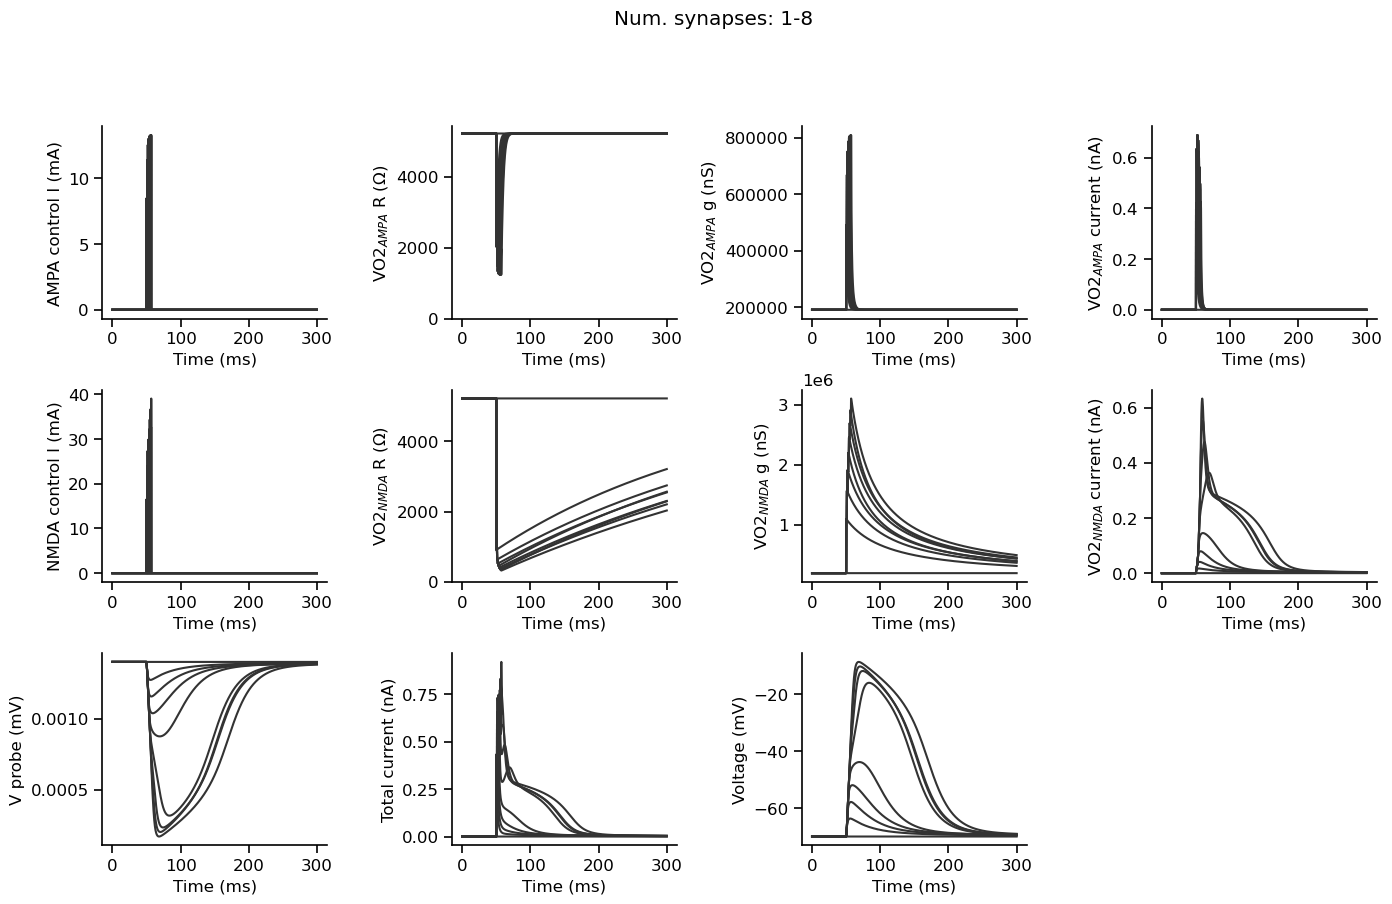

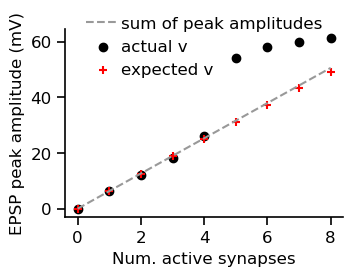

In [18]:
# Plot simulation results 

fig,ax = plt.subplots(3,4,figsize=(14,9))
titles = {'V': 'Voltage (mV)', 'I_total': 'Total current (nA)', 'V_probe': 'V probe (mV)', 
          'controlI_ampa': 'AMPA control I (mA)', 'controlI_nmda': 'NMDA control I (mA)',
          'I_ampa': 'VO2$_{AMPA}$ current (nA)',  'I_nmda': 'VO2$_{NMDA}$ current (nA)', 
          'R_ampa': 'VO2$_{AMPA}$ R (Ω)',         'R_nmda': 'VO2$_{NMDA}$ R (Ω)',
          'g_ampa': 'VO2$_{AMPA}$ g (nS)',        'g_nmda': 'VO2$_{NMDA}$ g (nS)'}

line_color = [0.2,0.2,0.2]

col=0
ax[0,col].plot(time, simulation_results['controlI_ampa'], c=line_color)
ax[0,col].set_xlabel('Time (ms)')
ax[0,col].set_ylabel(titles['controlI_ampa'])

ax[1,col].plot(time, simulation_results['controlI_nmda'], c=line_color)
ax[1,col].set_xlabel('Time (ms)')
ax[1,col].set_ylabel(titles['controlI_nmda'])
col+=1

ax[0,col].plot(time, simulation_results['R_ampa'], c=line_color)
ax[0,col].set_xlabel('Time (ms)')
ax[0,col].set_ylabel(titles['R_ampa'])
ax[0,col].set_ylim(bottom=0)

ax[1,col].plot(time, simulation_results['R_nmda'], c=line_color)
ax[1,col].set_xlabel('Time (ms)')
ax[1,col].set_ylabel(titles['R_nmda'])
ax[1,col].set_ylim(bottom=0)
col+=1

ax[0,col].plot(time, simulation_results['g_ampa'], c=line_color)
ax[0,col].set_xlabel('Time (ms)')
ax[0,col].set_ylabel(titles['g_ampa'])

ax[1,col].plot(time, simulation_results['g_nmda'], c=line_color)
ax[1,col].set_xlabel('Time (ms)')
ax[1,col].set_ylabel(titles['g_nmda'])
col+=1

ax[0,col].plot(time, simulation_results['I_ampa'], c=line_color)
ax[0,col].set_xlabel('Time (ms)')
ax[0,col].set_ylabel(titles['I_ampa'])

ax[1,col].plot(time, simulation_results['I_nmda'], c=line_color)
ax[1,col].set_xlabel('Time (ms)')
ax[1,col].set_ylabel(titles['I_nmda'])
col+=1


plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle(f'Num. synapses: 1-{synapse_range}')


col=0
ax[2,col].plot(time, simulation_results['V_probe'], c=line_color)
ax[2,col].set_xlabel('Time (ms)')
ax[2,col].set_ylabel(titles['V_probe'])
col+=1

ax[2,col].plot(time, simulation_results['I_total'], c=line_color)
ax[2,col].set_xlabel('Time (ms)')
ax[2,col].set_ylabel(titles['I_total'])
col+=1

ax[2,col].plot(time, simulation_results['V']-70, c=line_color)
ax[2,col].set_xlabel('Time (ms)')
ax[2,col].set_ylabel(titles['V'])
baselines = simulation_results['single_EPSPs'][500,:]
summed_EPSP_trace = np.sum(simulation_results['single_EPSPs']-baselines,axis=1) + baselines[1]
# ax[2,col].plot(time,summed_EPSP_trace-70,'--',linewidth=2.5,alpha=0.8,color='r', label='expected voltage')
# ax[2,col].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

ax[2,3].axis('off')


singleEPSP_amplitudes = np.max(simulation_results['single_EPSPs'],axis=0) - baselines
linear_sum = np.cumsum(singleEPSP_amplitudes)
expected_amplitudes = np.max(np.cumsum(simulation_results['single_EPSPs']-baselines,axis=1),axis=0)
multiEPSP_amplitudes = np.max(simulation_results['V'],axis=0) - baselines
num_EPSPs = len(multiEPSP_amplitudes)

fig,ax = plt.subplots(figsize=[5,4])
ax.plot(np.arange(num_EPSPs), linear_sum, '--', c=[0.6,0.6,0.6], label='sum of peak amplitudes')
ax.scatter(np.arange(num_EPSPs), multiEPSP_amplitudes, color='k', label='actual v')
ax.scatter(np.arange(num_EPSPs), expected_amplitudes, marker='+',color='r',label='expected v')
ax.set_ylabel('EPSP peak amplitude (mV)')
ax.set_xlabel('Num. active synapses')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

plt.tight_layout(pad=5)
plt.subplots_adjust(top=0.8)

plt.show()